<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/1-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->


In [1]:
# %matplotlib inline

# !pip install deeptrack

# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.


## 1. Setup

Imports and defines the objects needed for this example.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

import deeptrack as dt
from deeptrack.extras import datasets

import tensorflow as tf
import tensorflow_probability as tfp

# Download dataset from the cloud
datasets.load("MNIST")

PATH_TO_DATASET = os.path.abspath("./datasets/MNIST")

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, "training_set.npy")

VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, "validation_set.npy")
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, "validation_labels.npy")


c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Dataset already downloaded.


## 2. Defining the dataset

### 2.1 Loading the data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage`.


In [2]:
# Load the images from storage
get_training_images = dt.LoadImage(path=TRAINING_SET_PATH)[..., np.newaxis]

Since all training data is contained in a single file, we explicitly load the images


In [3]:
training_images = get_training_images.resolve()

We want to continuously generate new data for the network to train on. For this, we use the Dataset feature.


In [4]:
training_data_iterator = itertools.cycle(training_images)

training_iterator = dt.Dataset(
    data=training_data_iterator,
)

We normalize the images before feeding them to the network.

In [5]:
normalization = dt.NormalizeMinMax(0, 1)

We add the augmentations to the pipeline


In [6]:
training_set = training_iterator >> normalization

### 2.3 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.


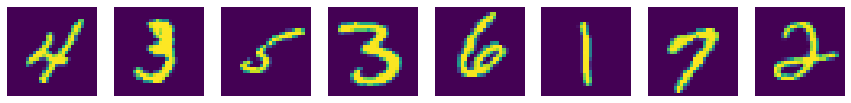

In [9]:
NUMBER_OF_IMAGES = 8


plt.figure(figsize=(15, 3))

for image_index in range(NUMBER_OF_IMAGES):

    training_set.update()

    image = training_iterator()

    plt.subplot(1, NUMBER_OF_IMAGES, image_index + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.


In [11]:
model = dt.models.VAE()


class binary_crossentropy(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(y_true, y_pred),
                axis=(1, 2),
            )
        )


model.compile(
    loss=binary_crossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
)

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.


In [12]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        training_set & training_set,
        batch_size=64,
        min_data_size=1000,
        max_data_size=2000,
    )

    with generator:
        h = model.fit(generator, epochs=100)
        
else:
    model_path = datasets.load_model("")
    model.load_weights(model_path)

Generating 1404 / 1000 samples before starting training
Epoch 1/100
15/15 [==============================] - 8s 539ms/step - loss: 516.4960 - reconstruction_loss: 512.8694 - kl_loss: 3.6266
Epoch 2/100
15/15 [==============================] - 9s 624ms/step - loss: 236.9094 - reconstruction_loss: 236.6112 - kl_loss: 0.2983
Epoch 3/100
15/15 [==============================] - 9s 606ms/step - loss: 211.0280 - reconstruction_loss: 210.7466 - kl_loss: 0.2814
Epoch 4/100
15/15 [==============================] - 9s 613ms/step - loss: 202.5035 - reconstruction_loss: 201.7479 - kl_loss: 0.7556
Epoch 5/100
15/15 [==============================] - 9s 615ms/step - loss: 197.1534 - reconstruction_loss: 195.3776 - kl_loss: 1.7757
Epoch 6/100
15/15 [==============================] - 10s 645ms/step - loss: 195.0985 - reconstruction_loss: 193.6134 - kl_loss: 1.4850
Epoch 7/100
15/15 [==============================] - 9s 589ms/step - loss: 190.3378 - reconstruction_loss: 188.8105 - kl_loss: 1.5273
Epoch

## 5. Evaluating the network


### 5.1 Generate images from latent space


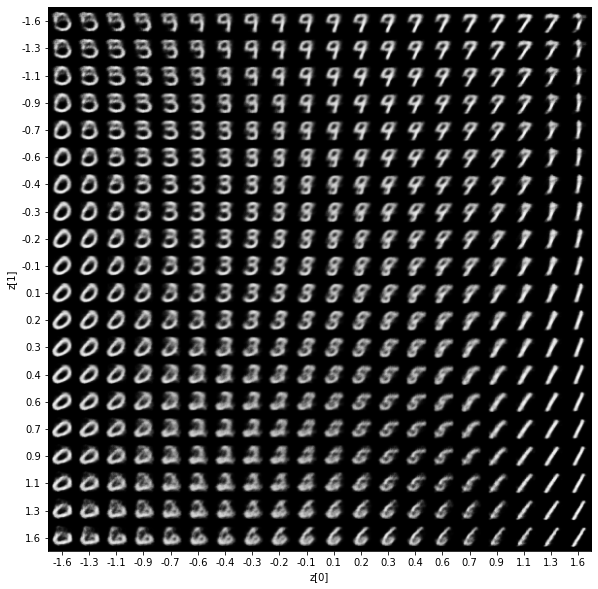

In [13]:
NUM_OF_IMAGES = 20
IMG_SIZE = 28

# Create a grid of latent space vectors
norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, NUM_OF_IMAGES))
grid_y = norm.quantile(np.linspace(0.05, 0.95, NUM_OF_IMAGES))

image = np.zeros((28 * NUM_OF_IMAGES,) * 2)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create a latent space vector
        z = np.array([[xi, yi]])

        # Decode the vector
        gimg = model.decoder(z)

        image[
            i * IMG_SIZE : (i + 1) * IMG_SIZE,
            j * IMG_SIZE : (j + 1) * IMG_SIZE,
        ] = gimg.numpy()[..., 0]


plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")

start = IMG_SIZE // 2
end = NUM_OF_IMAGES * IMG_SIZE + start
pixel_range = np.arange(start, end, IMG_SIZE)

sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


### 5.2 Clustering images in latent space


In [14]:
# Load validation images and labels
get_validation_images = (
    dt.LoadImage(path=VALIDATION_SET_PATH)[..., np.newaxis] >> normalization
)
get_validation_labels = dt.LoadImage(path=VALIDATION_LABELS_PATH)

validation_images = get_validation_images.resolve()
validation_labels = get_validation_labels.resolve()

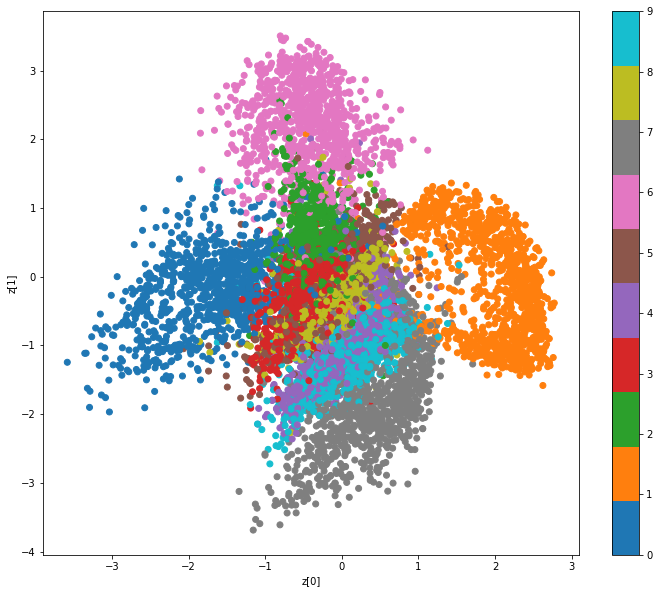

In [15]:
z_mean, _ = tf.split(
    model.encoder(validation_images._value), num_or_size_splits=2, axis=1
)

# plot latent space
plt.figure(figsize=(12, 10))
plt.scatter(
    z_mean[:, 0],
    z_mean[:, 1],
    c=validation_labels,
    cmap="tab10",
)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()
